In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping

What is the use of os in python 

In [4]:
import os
Landsat_folder_path=("Landsat image 2013/All_bands")
# print(Landsat_folder_path)

# Landsat_band_path 
Landsat_bands_path=[os.path.join(Landsat_folder_path,i) 
               for i in os.listdir(Landsat_folder_path) if os.path.isfile(os.path.join(Landsat_folder_path,i))]

Landsat_bands_path.sort()  
Landsat_bands_path    

['Landsat image 2013/All_bands\\LC08_L1TP_141041_20130326_20170505_01_T1_B1.TIF',
 'Landsat image 2013/All_bands\\LC08_L1TP_141041_20130326_20170505_01_T1_B2.TIF',
 'Landsat image 2013/All_bands\\LC08_L1TP_141041_20130326_20170505_01_T1_B3.TIF',
 'Landsat image 2013/All_bands\\LC08_L1TP_141041_20130326_20170505_01_T1_B4.TIF',
 'Landsat image 2013/All_bands\\LC08_L1TP_141041_20130326_20170505_01_T1_B5.TIF',
 'Landsat image 2013/All_bands\\LC08_L1TP_141041_20130326_20170505_01_T1_B6.TIF',
 'Landsat image 2013/All_bands\\LC08_L1TP_141041_20130326_20170505_01_T1_B7.TIF',
 'Landsat image 2013/All_bands\\LC08_L1TP_141041_20130326_20170505_01_T1_B8.TIF']

Now we need a rasterio dataset object containing all bands in order to use the mask() function and extract pixel values using geospatial polygons.

We'll do this by creating a new raster dataset and saving it for future uses.


In [10]:
# create a products directory within the data dir which won't be uploaded to Github
image_dir= "data/products/"

# check to see if the dir it exists, if not, create it
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
    
# filepath for image we're writing out
image_folder_path=image_dir+"Landsat_bands_composite.tif"
print(image_folder_path)


# Read metadata of first file and assume all other bands are the same
with rasterio.open(Landsat_bands_path[0]) as Land_band_0:
    meta_data=Land_band_0.meta
    

# Update metadata to reflect the number of layers
print(meta_data) 
meta_data.update({"count":len(Landsat_bands_path)})
print(meta_data)
# OR
# meta_data.update(count=len(Landsat_bands_path))
# print(meta_data)

# Read each layer and write it to stack
with rasterio.open(image_folder_path, 'w', **meta_data) as composite_band:
    for count, layer in enumerate(Landsat_bands_path, start=1):
        with rasterio.open(layer) as Land_band_1:
            composite_band.write_band(count, Land_band_1.read(1)) #read to convert into array

data/products/Landsat_bands_composite.tif
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7441, 'height': 7421, 'count': 1, 'crs': CRS.from_dict(init='epsg:32645'), 'transform': Affine(30.0, 0.0, 237585.0,
       0.0, -30.0, 3146115.0)}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7441, 'height': 7421, 'count': 8, 'crs': CRS.from_dict(init='epsg:32645'), 'transform': Affine(30.0, 0.0, 237585.0,
       0.0, -30.0, 3146115.0)}


In [191]:
composite=rasterio.open(image_folder_path)
print(composite.shape)
print(composite.count)

(7421, 7441)
8




Let's clip the image and take a look where we know the training data was from the last lesson (on the NC Rachel Carson Reserve) just to make sure it looks normal:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 450, 1150)


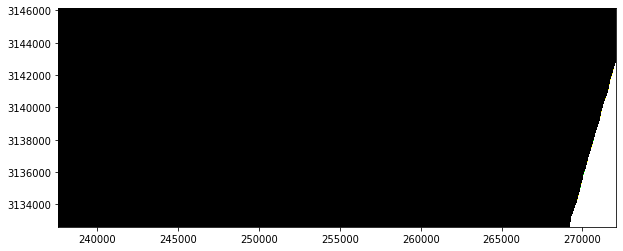

In [31]:
from rasterio.plot import show

composite_in_array=composite.read([4,3,2])[:, 150:600, 250:1400]# Only read three of the bands and selective heightand width
print(composite_in_array.shape)

# Lets plot the raster now
fig,ax=plt.subplots(figsize=(10,7))
show(composite_in_array[:, :, :], ax=ax, transform=composite.transform) 




Okay looks good! Our raster dataset is ready!
Now our goal is to get the pixels from the raster as outlined in each shapefile.

Our training data, the shapefile we've worked with, contains one main field we care about:

   a Classname field (String datatype)

Combined with the innate location information of polygons in a Shapefile, we have all that we need to use for pairing labels with the information in our raster.

However, in order to pair up our vector data with our raster pixels, we will need a way of co-aligning the datasets in space.

We'll do this using the rasterio mask function which takes in a dataset and a polygon and then outputs a numpy array with the pixels in the polygon.

Let's run through an example:


In [32]:
composite.crs

CRS.from_dict(init='epsg:32645')

In [156]:
kathmandu_shapefile=gpd.read_file(r"C:\Users\user\Downloads\GIS_self_project\kathmandu_classified_deep_learning.shp")
kathmandu_shapefile.crs

{'init': 'epsg:32645'}

In [157]:
kathmandu_shapefile=kathmandu_shapefile.to_crs({"init":"epsg:32645"})

In [158]:
len(kathmandu_shapefile)

17405

In [201]:
kathmandu_shapefile.columns

Index(['OBJECTID', 'Id', 'Classname', 'Shape_Leng', 'Shape_Area', 'geometry'], dtype='object')

In [198]:
kathmandu_shapefile["Classname"][14]


26

Now we want to extract the geometry of each feature in the shapefile in GeoJSON format:

In [159]:
print(kathmandu_shapefile.values)

[[1 1 1 180.000000002 1800.00000003
 [2 2 1 330.730401102 4658.2611777
 [3 3 1 119.999999996 899.999999944
 ...
 [17403 17403 1 120.0 900.0
 [17404 17404 1 807.749932817 14816.5819543
 [17405 17405 26 30004.513804 1309974.39518


In [160]:
# this generates a list of shapely geometries
geoms=kathmandu_shapefile.geometry.values
print(geoms)

<GeometryArray>
 ...
Length: 17405, dtype: geometry


In [187]:
# let's grab a single shapely geometry to check
geometry=geoms[0]
print(type(geometry))

# transform to GeoJSON format
from shapely.geometry import mapping
features=[mapping(geometry)]          # can also do this using polygon.__geo_interface__
print(type(features))
print(features)



<class 'shapely.geometry.polygon.Polygon'>
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((347181.09350611316, 3077934.320210689), (347181.0935061127, 3077964.3202106897), (347241.0935061133, 3077964.3202106897), (347241.0935061136, 3077934.320210689), (347181.09350611316, 3077934.320210689)),)}]


Now let's extract the raster values values within the polygon using the rasterio mask() function

In [192]:
out_raster,out_transform=mask(composite,features,crop=True)
print(out_raster.shape)
print(type(out_raster))

(8, 2, 3)
<class 'numpy.ndarray'>




Okay those looks like the right dimensions for our training data. 8 bands and 6x8 pixels seems reasonable given our earlier explorations.

We'll be doing a lot of memory intensive work so let's clean up and close this dataset.


In [193]:
composite.close()

# Building the Training Data for scikit-learn

Now let's do it for all features in the shapefile and create an array X that has all the pixels and an array y that has all the training labels.


In [212]:
X = np.array([], dtype=np.int8).reshape(0,8) # pixels for training
y = np.array([], dtype=np.string_) # labels for training
with rasterio.open(image_folder_path) as composite_1:
    band_count = composite_1.count
    print(band_count)
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]
        
    # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(composite_1, feature, crop=True) 
    # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed_1 = out_image[:,~np.all(out_image == 0, axis=0)]
        
    # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed_2 = out_image_trimmed_1[:,~np.all(out_image_trimmed_1 == 255, axis=0)]
        
    # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed_2.reshape(-1, band_count)

    #append the labels to the y array
        y = np.append(y,[kathmandu_shapefile["Classname"][index]] * out_image_reshaped.shape[0])  
    # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))     
        
print(out_image.shape)
print(out_image_trimmed_1.shape)
print(out_image_trimmed_2.shape)
print(out_image_reshaped.shape)        

8
(8, 66, 76)
(8, 1469)
(8, 1469)
(1469, 8)


In [220]:
print(X)
print(y[10:50])

[[ 9033  8993  8407 ...  8201  7709  7859]
 [13549 14019 12377 ... 10279  7432  7995]
 [ 9242  9131  9148 ...  9056  8464  8371]
 ...
 [ 8568  8342  8237 ...  8440  8286  8393]
 [ 8396  8493  8428 ...  8227  8501  8398]
 [ 8483  8170  8099 ...  8325  8315  8400]]
[b'1' b'12' b'12' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1'
 b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'26' b'1'
 b'1' b'1' b'1' b'1' b'1' b'1' b'26' b'1' b'26' b'1' b'1' b'1']


In [223]:
labels=np.unique(kathmandu_shapefile["Classname"])

In [225]:
print(labels.size
     )

3


In [226]:
# What are our classification labels?
labels = np.unique(kathmandu_shapefile["Classname"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 3 classes: [ 1 12 26]

Our X matrix is sized: (459360, 8)
Our y array is sized: (459360,)




It all looks good! Let's explore the spectral signatures of each class now to make sure they're actually separable since all we're going by in this classification is pixel values.


[b'1' b'12' b'26']


Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

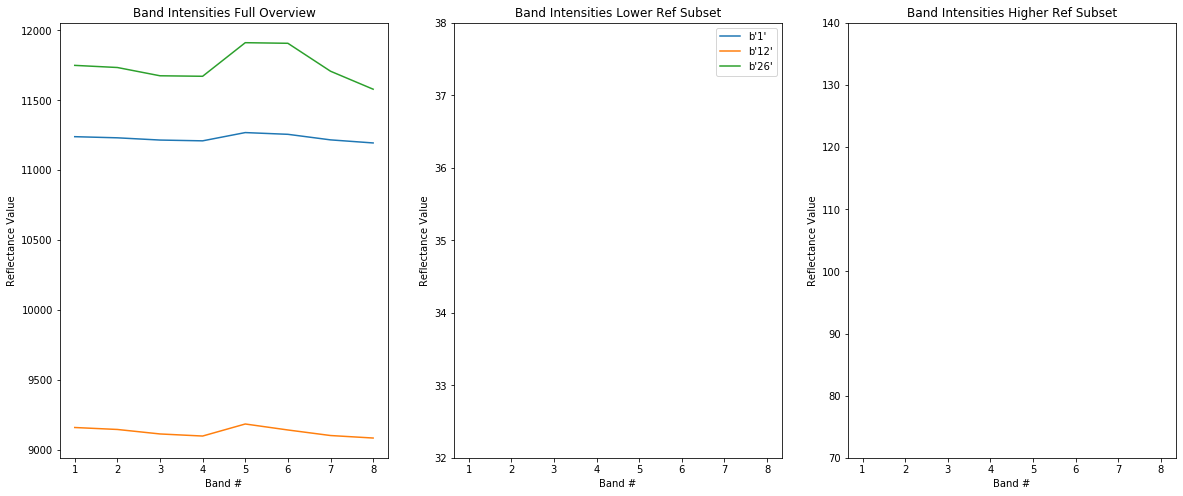

In [231]:
fig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-8
band_count = np.arange(1,9)

classes = np.unique(y)
print(classes)

for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
#ax[0].set_ylim(32,38)
ax[1].set_ylim(32,38)
ax[2].set_ylim(70,140)
#ax.set
ax[1].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

In [258]:
def str_class_to_int(class_array):
    class_array[class_array == b'1'] = 0
    class_array[class_array == b'12'] = 1
    class_array[class_array == b'26'] = 2
    return(class_array.astype(int))

In [259]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [260]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

In [261]:
with rasterio.open(image_folder_path) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:, 150:600, 250:1400]

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(8, 450, 1150)
(450, 1150, 8)


In [262]:
class_prediction = gnb.predict(reshaped_img.reshape(-1, 8))

# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

In [264]:
class_prediction = str_class_to_int(class_prediction)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


In [265]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland

))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


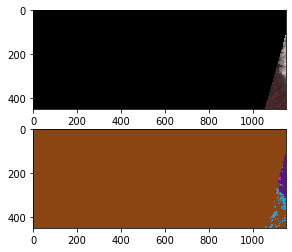

In [267]:
fig, axs = plt.subplots(2,1,figsize=(12,4))

img_stretched = color_stretch(reshaped_img, [4, 3, 2])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')

fig.show()